In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
root_folder = 'FC_GAN_results'
fixed_folder = root_folder + '/Fixed_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)

In [4]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [5]:
lr = 0.0001
prior_size = 100
train_epoch = 1000
batch_size = 250
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((50, 100))
fixed_target = F.one_hot(torch.arange(50) % 10, 10)

n_classes = 10

In [6]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        
    def forward(self, x, target):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        x = torch.cat([x, target.float()], dim=1)
        return self.model(x)

In [7]:
G = FullyConnected([prior_size + n_classes, 256, 512, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh())
D = FullyConnected([28*28 + n_classes, 1024, 512, 256, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), flatten=True)

G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

In [8]:
train_log = {'G': [], 'D': []}
test_log = {'G': [], 'D': []}

In [9]:
batch_zeros = torch.zeros((batch_size, 1))
batch_ones = torch.ones((batch_size, 1))

In [10]:
def train(epoch, G, D, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        target_onehot = F.one_hot(target, 10)
        # train D
        D.zero_grad()
        G.zero_grad()
        z = torch.randn((batch_size, prior_size))
        fake_pred = D(G(z, target_onehot), target_onehot)
        true_pred = D(data, target_onehot)
        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        D_loss = 0.5*(fake_loss + true_loss)
        
        D_loss.backward()
        D_optimizer.step()
        
        # train G
        D.zero_grad()
        G.zero_grad()
        z = torch.randn((batch_size, prior_size))
        fake_pred = D(G(z, target_onehot), target_onehot)
        G_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
        
        G_loss.backward()
        
        G_optimizer.step()
            
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
        print(line + losses)
        log['G'].append(G_loss.item())
        log['D'].append(D_loss.item())

In [11]:
def test(G, D, loader, epoch, log=None):
    test_size = len(loader)
    G_loss = 0.
    D_loss = 0.
    test_loss = {'G': 0., 'D': 0.}
    with torch.no_grad():
        for data, target in loader:
            target_onehot = F.one_hot(target, 10)
            z = torch.randn((batch_size, prior_size))
            fake_pred = D(G(z, target_onehot), target_onehot)
            true_pred = D(data, target_onehot)
        
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item()
            
            D_loss += 0.5*(fake_loss + true_loss)
            G_loss += F.binary_cross_entropy_with_logits(fake_pred, batch_ones).item()
    
    G_loss /= test_size
    D_loss /= test_size

    fixed_gen = G(fixed_z, fixed_target).data.numpy().reshape(50, 1, 28, 28)
    plot_mnist(fixed_gen, (5, 10), True, fixed_folder + '/%03d.png' % epoch)
    report = 'Test losses. G: {:.4f}, D: {:.4f}'.format(G_loss, D_loss)
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses G: 0.6975, D: 0.7037
Train Epoch: 1 [25000/50000 (50%)]	Losses G: 1.0758, D: 0.3532
Train Epoch: 1 [50000/50000 (100%)]	Losses G: 1.4170, D: 0.4775


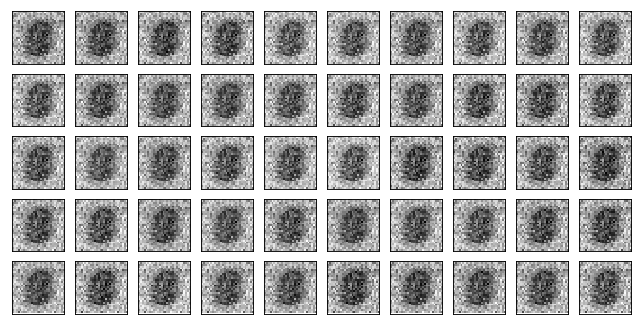

Test losses. G: 0.6292, D: 0.5105
Train Epoch: 2 [0/50000 (0%)]	Losses G: 1.2770, D: 0.5792
Train Epoch: 2 [25000/50000 (50%)]	Losses G: 2.0811, D: 0.3581
Train Epoch: 2 [50000/50000 (100%)]	Losses G: 2.4731, D: 0.2991


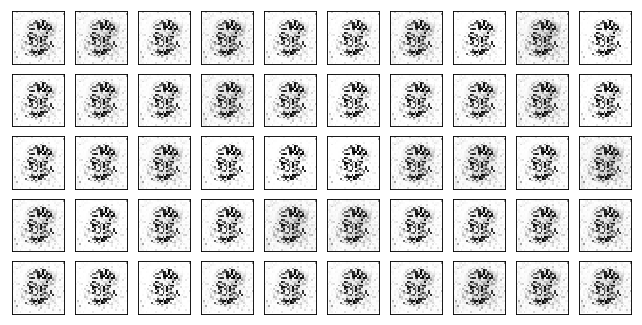

Test losses. G: 1.8694, D: 0.2159
Train Epoch: 3 [0/50000 (0%)]	Losses G: 2.5375, D: 0.2661
Train Epoch: 3 [25000/50000 (50%)]	Losses G: 0.9603, D: 0.8489
Train Epoch: 3 [50000/50000 (100%)]	Losses G: 1.7688, D: 0.4003


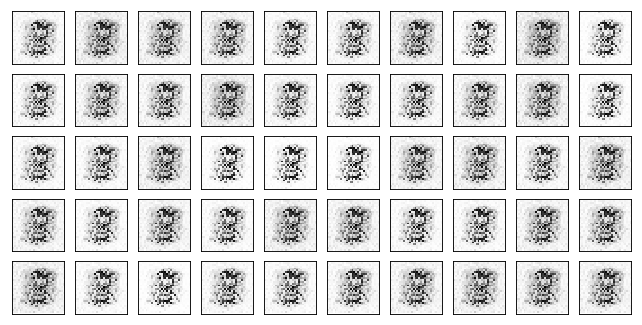

Test losses. G: 1.2935, D: 0.3616
Train Epoch: 4 [0/50000 (0%)]	Losses G: 1.8637, D: 0.3778
Train Epoch: 4 [25000/50000 (50%)]	Losses G: 0.5811, D: 0.8466
Train Epoch: 4 [50000/50000 (100%)]	Losses G: 1.5261, D: 0.4596


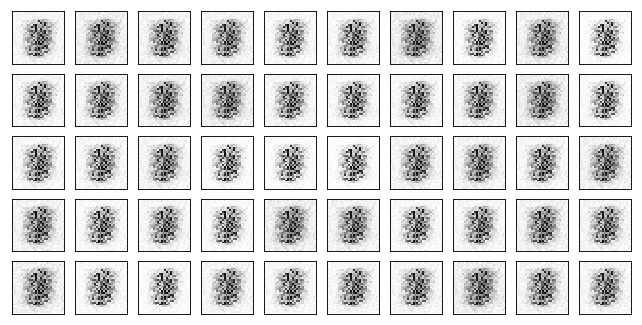

Test losses. G: 1.1134, D: 0.4248
Train Epoch: 5 [0/50000 (0%)]	Losses G: 1.5458, D: 0.4744
Train Epoch: 5 [25000/50000 (50%)]	Losses G: 0.5568, D: 0.8562
Train Epoch: 5 [50000/50000 (100%)]	Losses G: 0.9247, D: 0.6942


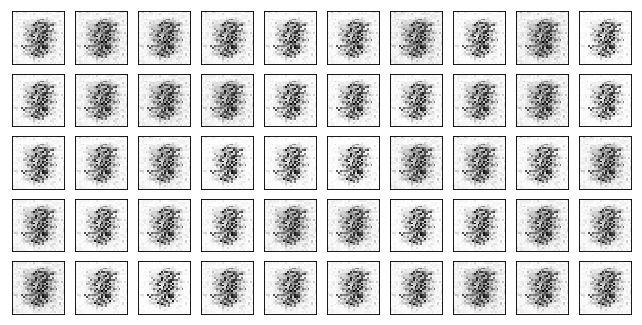

Test losses. G: 0.6947, D: 0.6329
Train Epoch: 6 [0/50000 (0%)]	Losses G: 0.9711, D: 0.6444
Train Epoch: 6 [25000/50000 (50%)]	Losses G: 2.7986, D: 0.2047
Train Epoch: 6 [50000/50000 (100%)]	Losses G: 3.7404, D: 0.0915


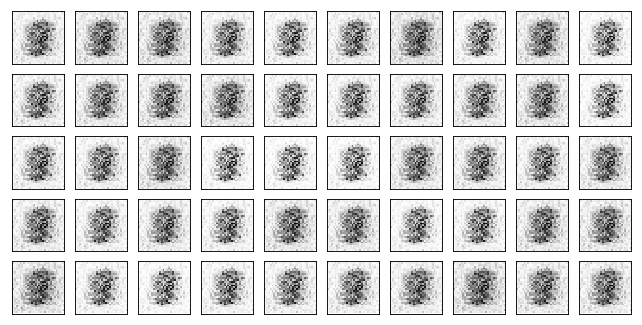

Test losses. G: 3.1299, D: 0.0509
Train Epoch: 7 [0/50000 (0%)]	Losses G: 3.6324, D: 0.1004
Train Epoch: 7 [25000/50000 (50%)]	Losses G: 2.3864, D: 0.2866
Train Epoch: 7 [50000/50000 (100%)]	Losses G: 1.9738, D: 0.3713


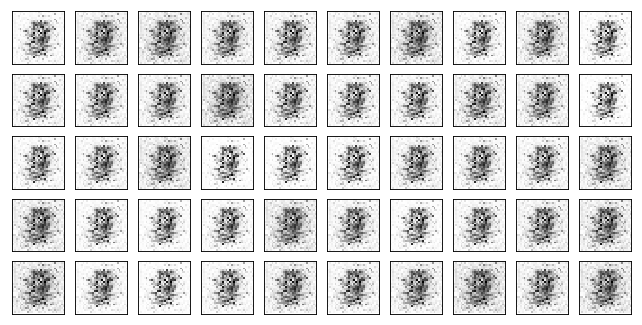

Test losses. G: 1.6150, D: 0.2104
Train Epoch: 8 [0/50000 (0%)]	Losses G: 2.0984, D: 0.3458
Train Epoch: 8 [25000/50000 (50%)]	Losses G: 4.8343, D: 0.0578
Train Epoch: 8 [50000/50000 (100%)]	Losses G: 3.2174, D: 0.1845


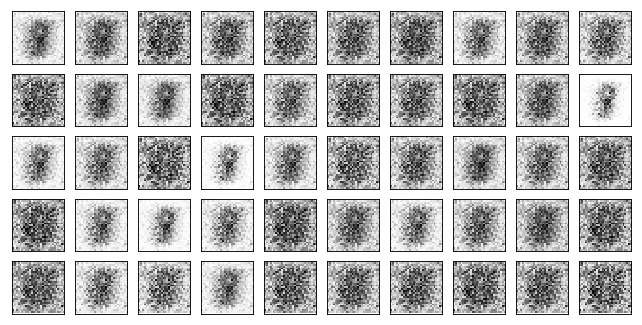

Test losses. G: 2.6067, D: 0.1027
Train Epoch: 9 [0/50000 (0%)]	Losses G: 3.4256, D: 0.1499
Train Epoch: 9 [25000/50000 (50%)]	Losses G: 5.0883, D: 0.0617
Train Epoch: 9 [50000/50000 (100%)]	Losses G: 3.8281, D: 0.1031


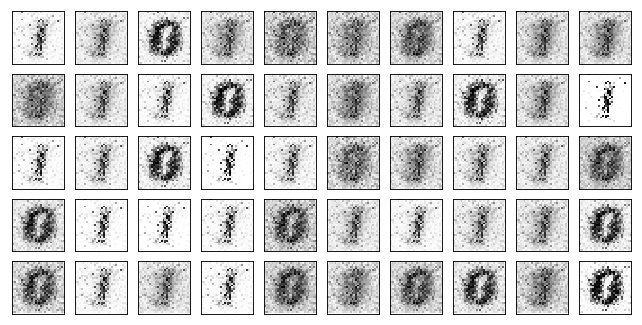

Test losses. G: 3.1949, D: 0.0414
Train Epoch: 10 [0/50000 (0%)]	Losses G: 4.0039, D: 0.1300
Train Epoch: 10 [25000/50000 (50%)]	Losses G: 3.6399, D: 0.1781
Train Epoch: 10 [50000/50000 (100%)]	Losses G: 5.2830, D: 0.0637


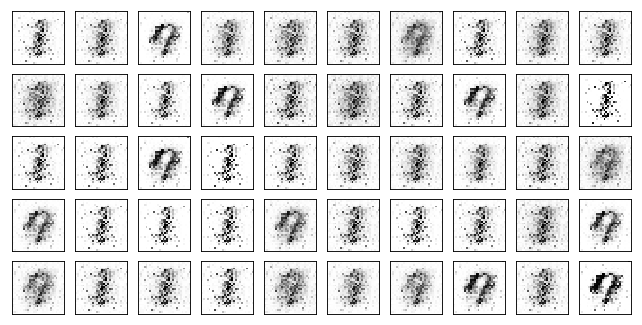

Test losses. G: 4.8060, D: 0.0254
Train Epoch: 11 [0/50000 (0%)]	Losses G: 4.7712, D: 0.0741
Train Epoch: 11 [25000/50000 (50%)]	Losses G: 6.3467, D: 0.1208
Train Epoch: 11 [50000/50000 (100%)]	Losses G: 5.4121, D: 0.0675


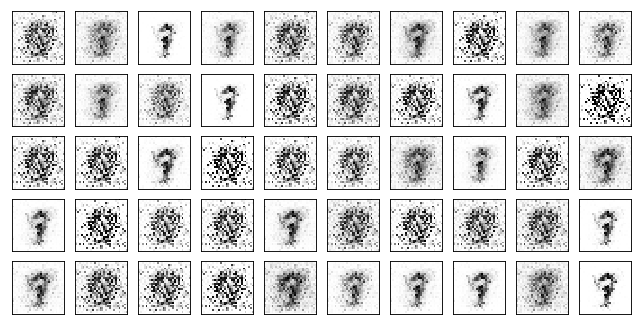

Test losses. G: 4.6782, D: 0.0181
Train Epoch: 12 [0/50000 (0%)]	Losses G: 4.8561, D: 0.0483
Train Epoch: 12 [25000/50000 (50%)]	Losses G: 4.7450, D: 0.0724
Train Epoch: 12 [50000/50000 (100%)]	Losses G: 6.5236, D: 0.0447


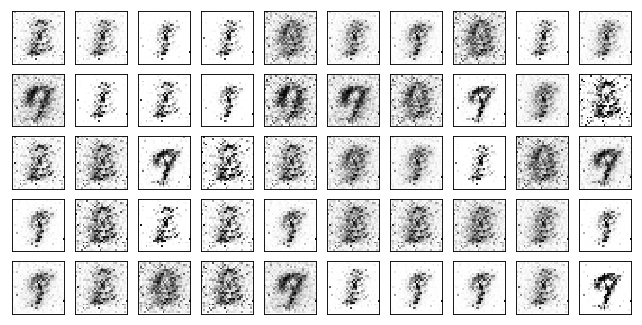

Test losses. G: 5.9061, D: 0.0174
Train Epoch: 13 [0/50000 (0%)]	Losses G: 6.1838, D: 0.0745
Train Epoch: 13 [25000/50000 (50%)]	Losses G: 4.8823, D: 0.0729
Train Epoch: 13 [50000/50000 (100%)]	Losses G: 6.2589, D: 0.0512


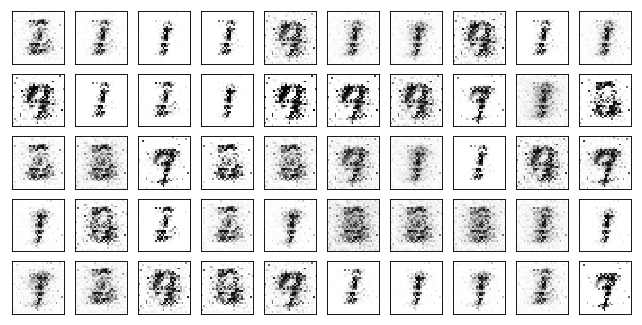

Test losses. G: 5.4935, D: 0.0060
Train Epoch: 14 [0/50000 (0%)]	Losses G: 6.8964, D: 0.0377
Train Epoch: 14 [25000/50000 (50%)]	Losses G: 5.1793, D: 0.0566
Train Epoch: 14 [50000/50000 (100%)]	Losses G: 6.3374, D: 0.0763


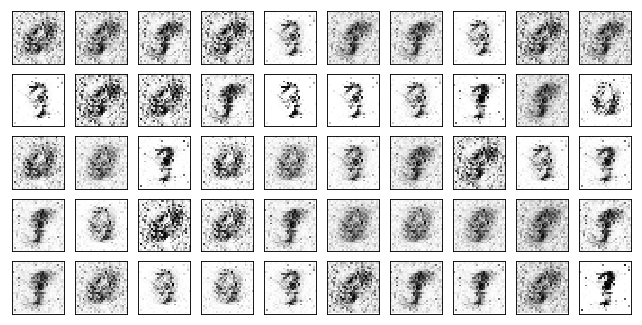

Test losses. G: 5.2505, D: 0.0327
Train Epoch: 15 [0/50000 (0%)]	Losses G: 5.5935, D: 0.0767
Train Epoch: 15 [25000/50000 (50%)]	Losses G: 5.6395, D: 0.1624
Train Epoch: 15 [50000/50000 (100%)]	Losses G: 6.3144, D: 0.0374


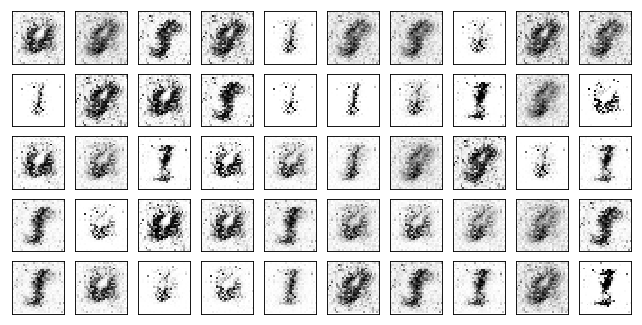

Test losses. G: 5.4370, D: 0.0112
Train Epoch: 16 [0/50000 (0%)]	Losses G: 6.3254, D: 0.0408
Train Epoch: 16 [25000/50000 (50%)]	Losses G: 5.1304, D: 0.0857
Train Epoch: 16 [50000/50000 (100%)]	Losses G: 5.8023, D: 0.1248


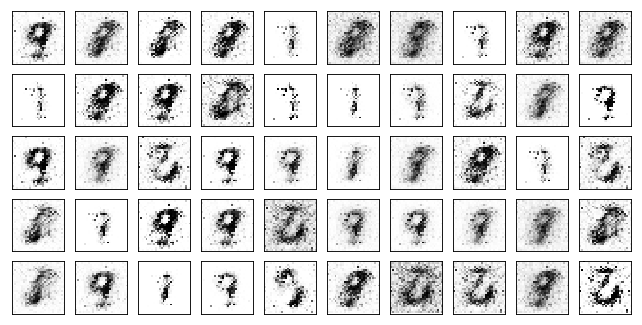

Test losses. G: 5.0923, D: 0.0451
Train Epoch: 17 [0/50000 (0%)]	Losses G: 4.8369, D: 0.1265
Train Epoch: 17 [25000/50000 (50%)]	Losses G: 3.6330, D: 0.0829
Train Epoch: 17 [50000/50000 (100%)]	Losses G: 5.2872, D: 0.0867


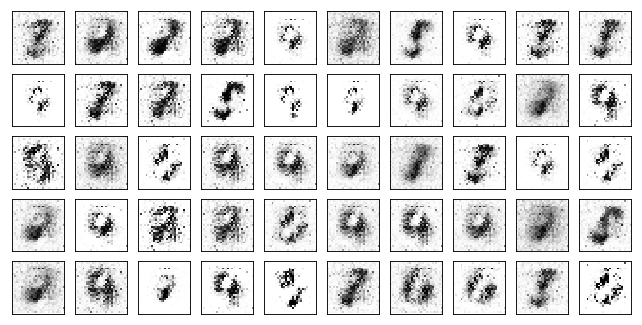

Test losses. G: 4.6224, D: 0.0180
Train Epoch: 18 [0/50000 (0%)]	Losses G: 5.3424, D: 0.0770
Train Epoch: 18 [25000/50000 (50%)]	Losses G: 4.9720, D: 0.1184
Train Epoch: 18 [50000/50000 (100%)]	Losses G: 5.0934, D: 0.0661


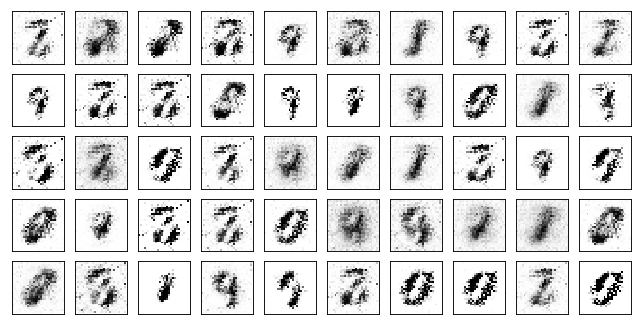

Test losses. G: 4.2838, D: 0.0197
Train Epoch: 19 [0/50000 (0%)]	Losses G: 5.5689, D: 0.1006
Train Epoch: 19 [25000/50000 (50%)]	Losses G: 5.0464, D: 0.0648
Train Epoch: 19 [50000/50000 (100%)]	Losses G: 6.1026, D: 0.0748


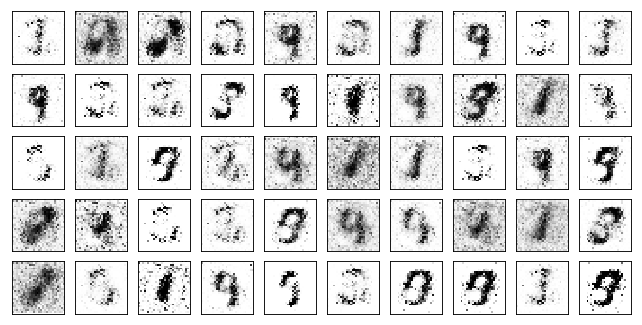

Test losses. G: 5.2019, D: 0.0196
Train Epoch: 20 [0/50000 (0%)]	Losses G: 5.2582, D: 0.0655
Train Epoch: 20 [25000/50000 (50%)]	Losses G: 6.4597, D: 0.1120
Train Epoch: 20 [50000/50000 (100%)]	Losses G: 5.3413, D: 0.0810


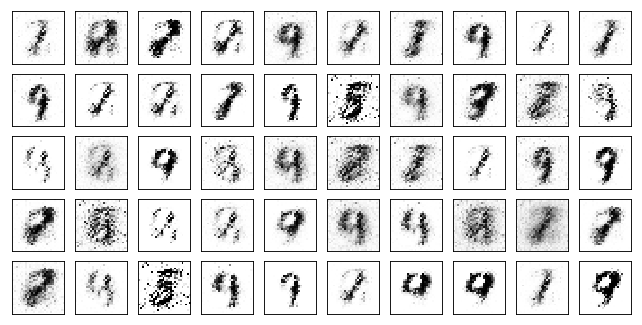

Test losses. G: 4.5639, D: 0.0297
Train Epoch: 21 [0/50000 (0%)]	Losses G: 5.5674, D: 0.0720
Train Epoch: 21 [25000/50000 (50%)]	Losses G: 5.6458, D: 0.0707
Train Epoch: 21 [50000/50000 (100%)]	Losses G: 5.6958, D: 0.1491


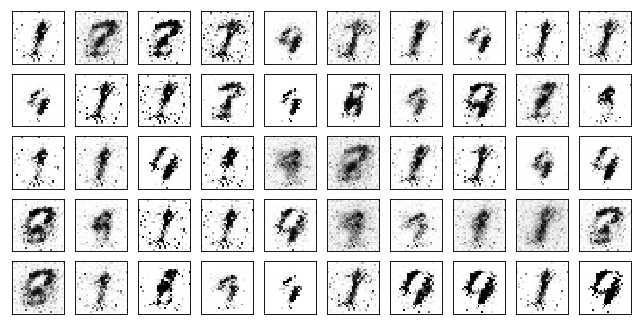

Test losses. G: 4.8074, D: 0.0272
Train Epoch: 22 [0/50000 (0%)]	Losses G: 6.6332, D: 0.0861
Train Epoch: 22 [25000/50000 (50%)]	Losses G: 4.3653, D: 0.1127
Train Epoch: 22 [50000/50000 (100%)]	Losses G: 5.8487, D: 0.1211


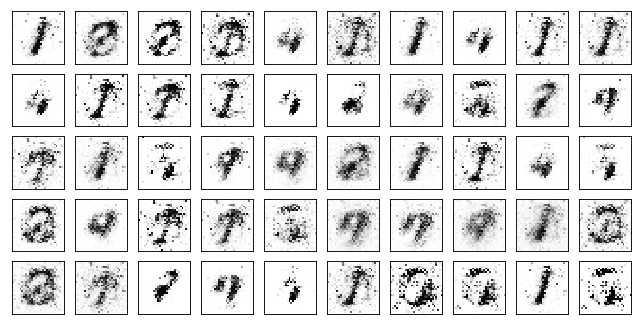

Test losses. G: 5.2004, D: 0.0186
Train Epoch: 23 [0/50000 (0%)]	Losses G: 5.9685, D: 0.0575
Train Epoch: 23 [25000/50000 (50%)]	Losses G: 4.2874, D: 0.0963
Train Epoch: 23 [50000/50000 (100%)]	Losses G: 5.4630, D: 0.0892


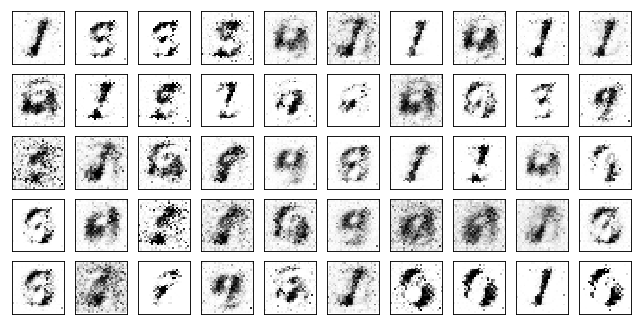

Test losses. G: 4.6620, D: 0.0317
Train Epoch: 24 [0/50000 (0%)]	Losses G: 5.7874, D: 0.0741
Train Epoch: 24 [25000/50000 (50%)]	Losses G: 6.3525, D: 0.0900
Train Epoch: 24 [50000/50000 (100%)]	Losses G: 4.3956, D: 0.0892


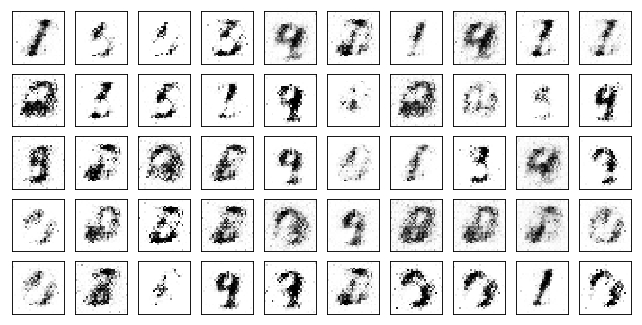

Test losses. G: 3.8267, D: 0.0394
Train Epoch: 25 [0/50000 (0%)]	Losses G: 5.1279, D: 0.0823
Train Epoch: 25 [25000/50000 (50%)]	Losses G: 5.6913, D: 0.0803
Train Epoch: 25 [50000/50000 (100%)]	Losses G: 6.3367, D: 0.0858


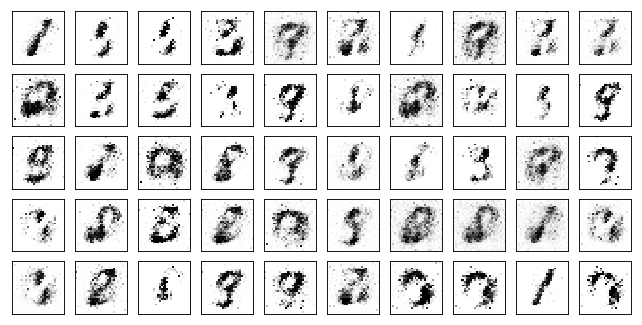

Test losses. G: 5.5974, D: 0.0397
Train Epoch: 26 [0/50000 (0%)]	Losses G: 5.7485, D: 0.0854
Train Epoch: 26 [25000/50000 (50%)]	Losses G: 4.5373, D: 0.1221
Train Epoch: 26 [50000/50000 (100%)]	Losses G: 4.5873, D: 0.0990


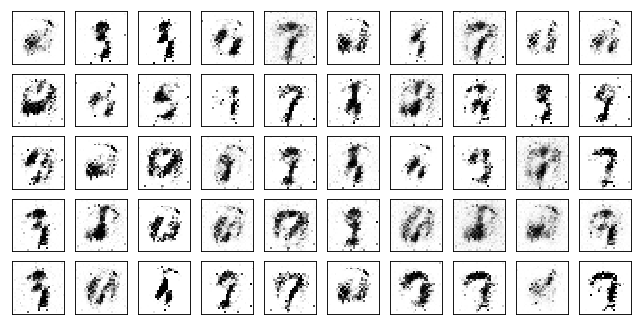

Test losses. G: 3.8442, D: 0.0346
Train Epoch: 27 [0/50000 (0%)]	Losses G: 5.0955, D: 0.0988
Train Epoch: 27 [25000/50000 (50%)]	Losses G: 5.8884, D: 0.0817
Train Epoch: 27 [50000/50000 (100%)]	Losses G: 4.7814, D: 0.1102


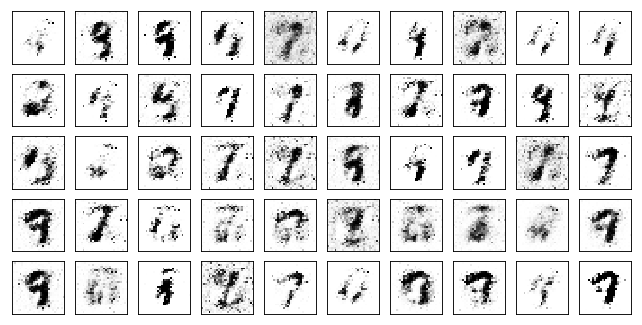

Test losses. G: 4.2144, D: 0.0286
Train Epoch: 28 [0/50000 (0%)]	Losses G: 5.6265, D: 0.0990
Train Epoch: 28 [25000/50000 (50%)]	Losses G: 5.1136, D: 0.0983
Train Epoch: 28 [50000/50000 (100%)]	Losses G: 5.5691, D: 0.1323


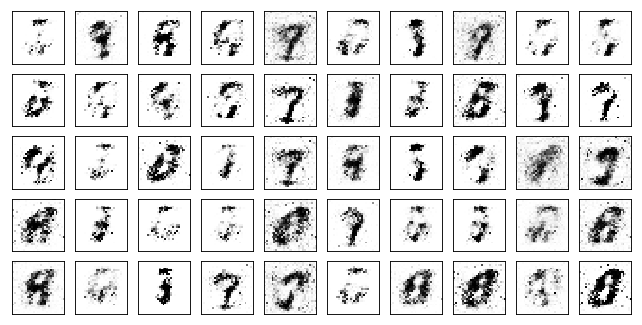

Test losses. G: 4.7351, D: 0.0542
Train Epoch: 29 [0/50000 (0%)]	Losses G: 6.2143, D: 0.0906
Train Epoch: 29 [25000/50000 (50%)]	Losses G: 4.6073, D: 0.1043
Train Epoch: 29 [50000/50000 (100%)]	Losses G: 5.6436, D: 0.1209


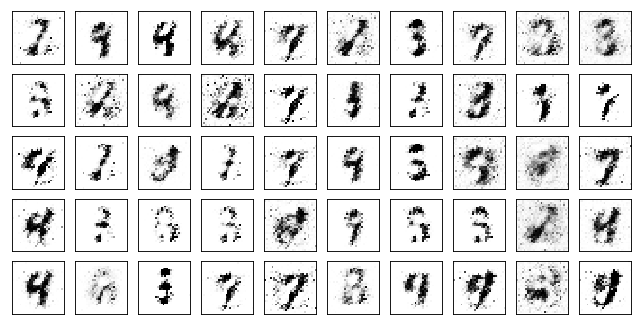

Test losses. G: 5.2968, D: 0.0320
Train Epoch: 30 [0/50000 (0%)]	Losses G: 6.8735, D: 0.0807
Train Epoch: 30 [25000/50000 (50%)]	Losses G: 5.9490, D: 0.0903
Train Epoch: 30 [50000/50000 (100%)]	Losses G: 4.7339, D: 0.1320


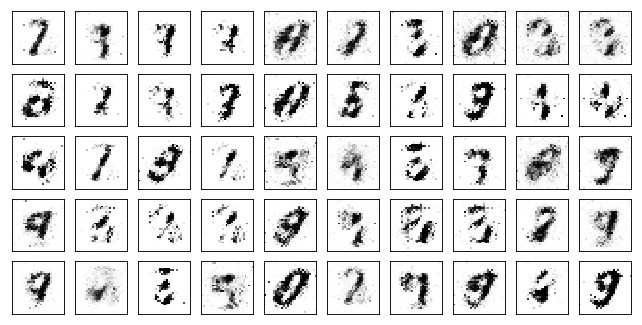

Test losses. G: 4.1656, D: 0.0414


In [12]:
for epoch in range(1, 31):
    G.train()
    D.train()
    train(epoch, G, D, train_log)
    G.eval()
    D.eval()
    test(G, D, valid_loader, epoch, test_log)

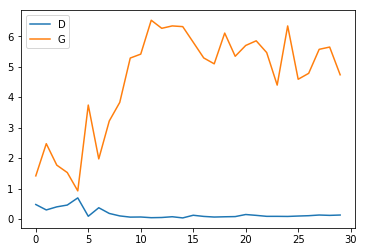

In [16]:
plt.plot(train_log['D'], label='D')
plt.plot(train_log['G'], label='G')
plt.legend()
plt.show()

Train Epoch: 1 [0/50000 (0%)]	Losses G: 4.0778, D: 0.0988
Train Epoch: 1 [25000/50000 (50%)]	Losses G: 4.9020, D: 0.0942
Train Epoch: 1 [50000/50000 (100%)]	Losses G: 4.8891, D: 0.0739


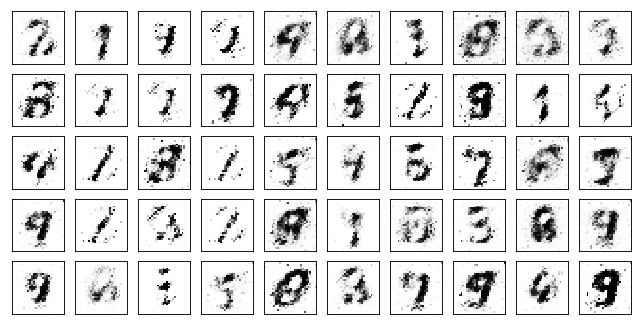

Test losses. G: 4.4971, D: 0.0353
Train Epoch: 2 [0/50000 (0%)]	Losses G: 5.0466, D: 0.1225
Train Epoch: 2 [25000/50000 (50%)]	Losses G: 5.0610, D: 0.1172
Train Epoch: 2 [50000/50000 (100%)]	Losses G: 4.5237, D: 0.1746


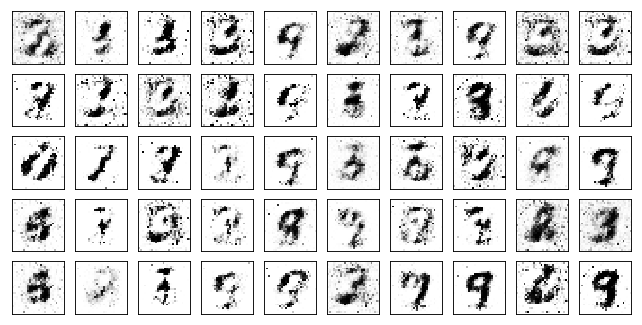

Test losses. G: 3.9560, D: 0.0578
Train Epoch: 3 [0/50000 (0%)]	Losses G: 4.5774, D: 0.1362
Train Epoch: 3 [25000/50000 (50%)]	Losses G: 4.7160, D: 0.1468
Train Epoch: 3 [50000/50000 (100%)]	Losses G: 4.6353, D: 0.1313


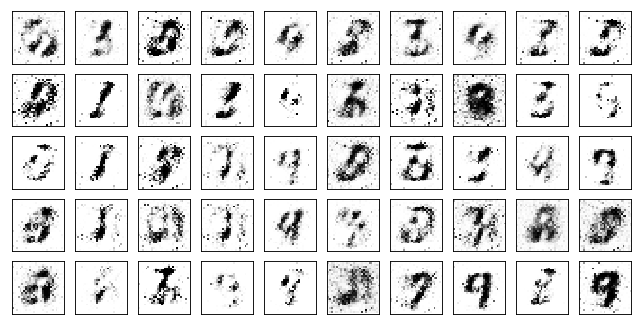

Test losses. G: 4.0570, D: 0.0437
Train Epoch: 4 [0/50000 (0%)]	Losses G: 5.2449, D: 0.0834
Train Epoch: 4 [25000/50000 (50%)]	Losses G: 4.6262, D: 0.1255
Train Epoch: 4 [50000/50000 (100%)]	Losses G: 4.9123, D: 0.1474


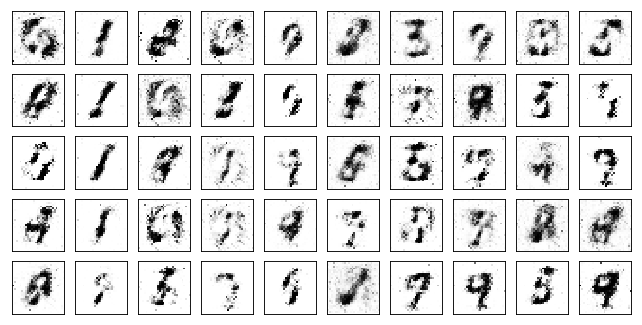

Test losses. G: 4.3350, D: 0.0476
Train Epoch: 5 [0/50000 (0%)]	Losses G: 4.0415, D: 0.1228
Train Epoch: 5 [25000/50000 (50%)]	Losses G: 4.9948, D: 0.1771
Train Epoch: 5 [50000/50000 (100%)]	Losses G: 3.6242, D: 0.1485


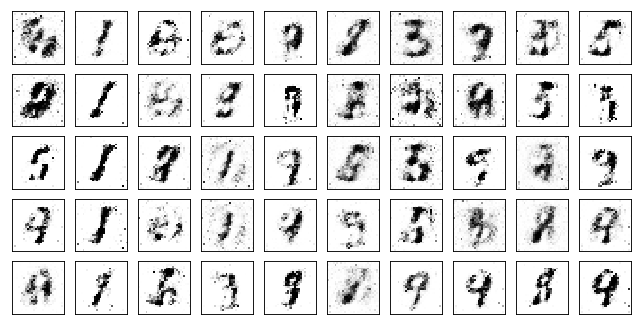

Test losses. G: 3.3326, D: 0.0670
Train Epoch: 6 [0/50000 (0%)]	Losses G: 4.0121, D: 0.1658
Train Epoch: 6 [25000/50000 (50%)]	Losses G: 5.4681, D: 0.1000
Train Epoch: 6 [50000/50000 (100%)]	Losses G: 3.6086, D: 0.2214


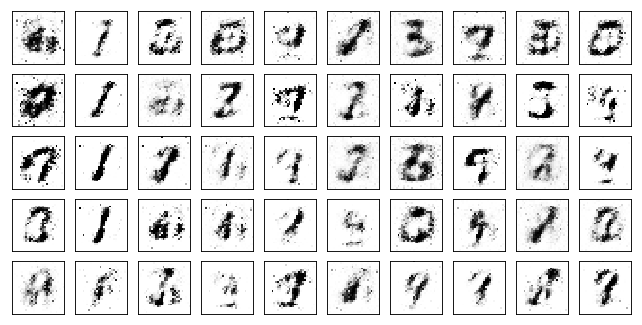

Test losses. G: 3.2464, D: 0.0807
Train Epoch: 7 [0/50000 (0%)]	Losses G: 4.5233, D: 0.1517
Train Epoch: 7 [25000/50000 (50%)]	Losses G: 4.0119, D: 0.1724
Train Epoch: 7 [50000/50000 (100%)]	Losses G: 4.1407, D: 0.1101


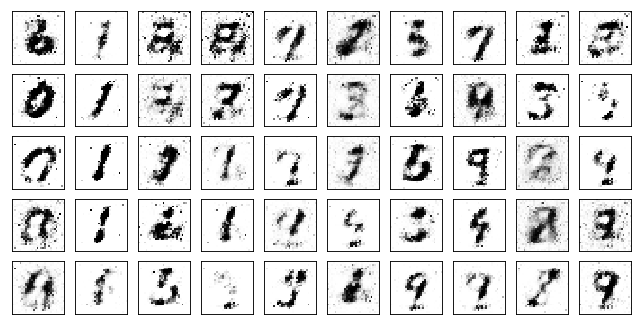

Test losses. G: 3.7134, D: 0.0566
Train Epoch: 8 [0/50000 (0%)]	Losses G: 4.3206, D: 0.1000
Train Epoch: 8 [25000/50000 (50%)]	Losses G: 3.8904, D: 0.1246
Train Epoch: 8 [50000/50000 (100%)]	Losses G: 4.5354, D: 0.1599


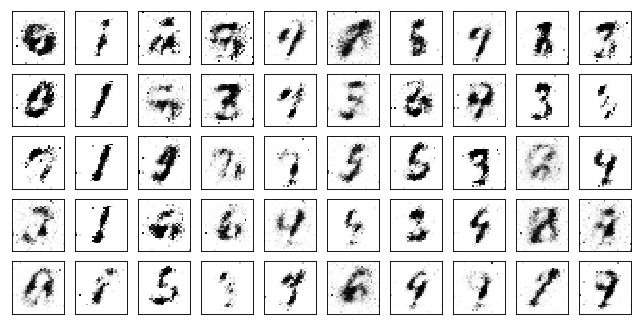

Test losses. G: 4.2921, D: 0.0949
Train Epoch: 9 [0/50000 (0%)]	Losses G: 4.2920, D: 0.1595
Train Epoch: 9 [25000/50000 (50%)]	Losses G: 4.3346, D: 0.1328
Train Epoch: 9 [50000/50000 (100%)]	Losses G: 3.6761, D: 0.1456


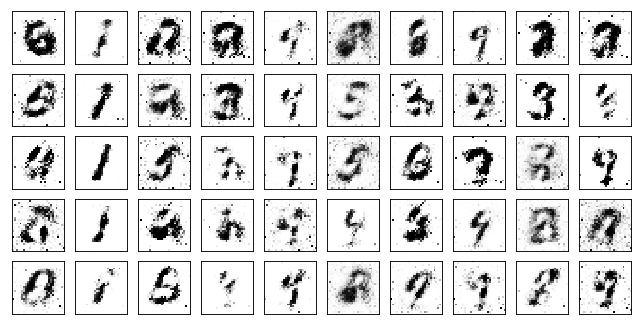

Test losses. G: 3.2448, D: 0.0888
Train Epoch: 10 [0/50000 (0%)]	Losses G: 3.5006, D: 0.1978
Train Epoch: 10 [25000/50000 (50%)]	Losses G: 4.0451, D: 0.1732
Train Epoch: 10 [50000/50000 (100%)]	Losses G: 4.2723, D: 0.1348


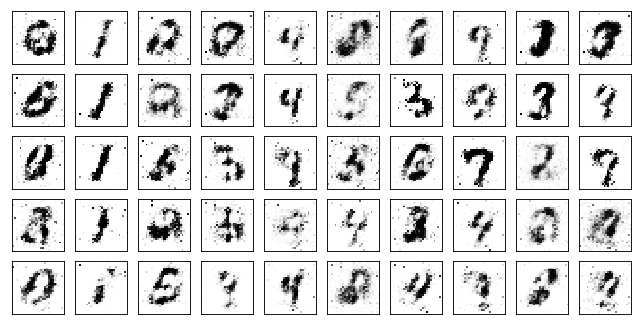

Test losses. G: 3.6817, D: 0.0628
Train Epoch: 11 [0/50000 (0%)]	Losses G: 4.0564, D: 0.1172
Train Epoch: 11 [25000/50000 (50%)]	Losses G: 4.5855, D: 0.1682
Train Epoch: 11 [50000/50000 (100%)]	Losses G: 3.2441, D: 0.2215


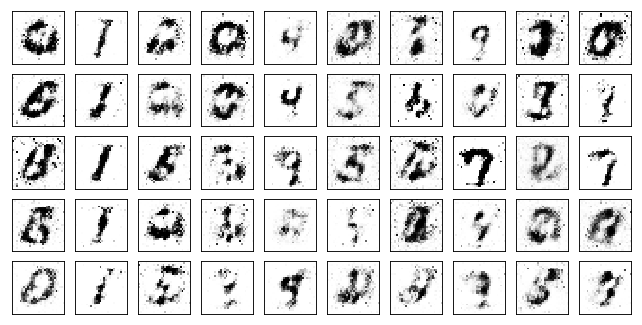

Test losses. G: 2.9756, D: 0.1124
Train Epoch: 12 [0/50000 (0%)]	Losses G: 3.3184, D: 0.2033
Train Epoch: 12 [25000/50000 (50%)]	Losses G: 3.3001, D: 0.2342
Train Epoch: 12 [50000/50000 (100%)]	Losses G: 4.0785, D: 0.1580


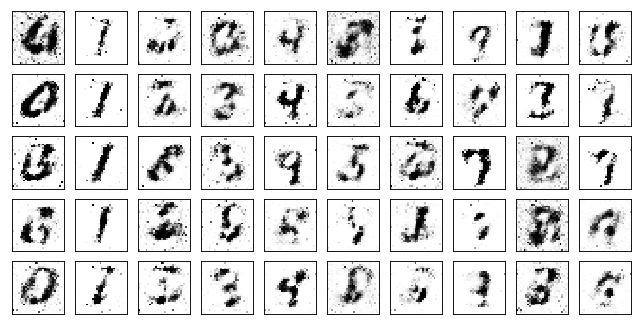

Test losses. G: 3.7201, D: 0.0846
Train Epoch: 13 [0/50000 (0%)]	Losses G: 4.0936, D: 0.1229
Train Epoch: 13 [25000/50000 (50%)]	Losses G: 3.3569, D: 0.1588
Train Epoch: 13 [50000/50000 (100%)]	Losses G: 3.6930, D: 0.1708


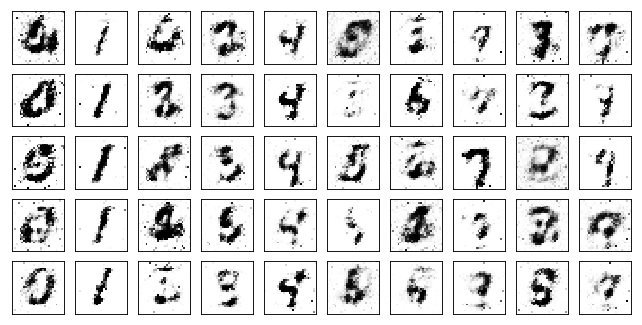

Test losses. G: 3.4506, D: 0.0929
Train Epoch: 14 [0/50000 (0%)]	Losses G: 3.6463, D: 0.1549
Train Epoch: 14 [25000/50000 (50%)]	Losses G: 2.8325, D: 0.2210
Train Epoch: 14 [50000/50000 (100%)]	Losses G: 3.8125, D: 0.1508


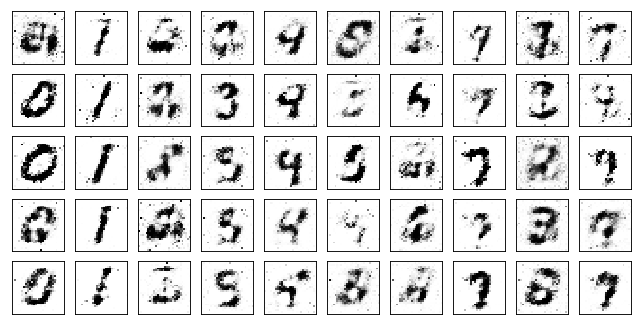

Test losses. G: 3.4377, D: 0.0714
Train Epoch: 15 [0/50000 (0%)]	Losses G: 3.7371, D: 0.1820
Train Epoch: 15 [25000/50000 (50%)]	Losses G: 2.8877, D: 0.2596
Train Epoch: 15 [50000/50000 (100%)]	Losses G: 3.8140, D: 0.2040


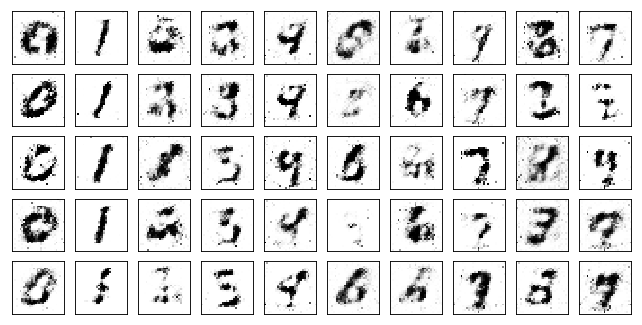

Test losses. G: 3.6453, D: 0.1051
Train Epoch: 16 [0/50000 (0%)]	Losses G: 3.2027, D: 0.1675
Train Epoch: 16 [25000/50000 (50%)]	Losses G: 3.8392, D: 0.1494
Train Epoch: 16 [50000/50000 (100%)]	Losses G: 3.0727, D: 0.2287


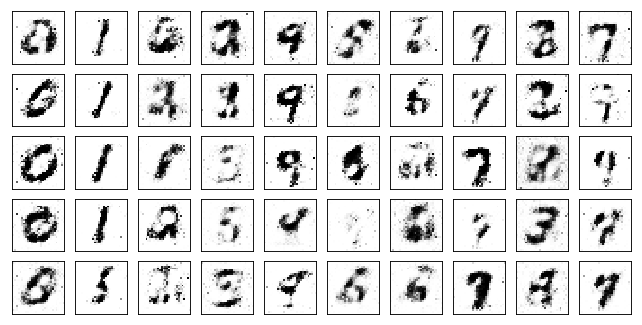

Test losses. G: 2.7022, D: 0.1384
Train Epoch: 17 [0/50000 (0%)]	Losses G: 3.0725, D: 0.2500
Train Epoch: 17 [25000/50000 (50%)]	Losses G: 3.7164, D: 0.2899
Train Epoch: 17 [50000/50000 (100%)]	Losses G: 2.4563, D: 0.2800


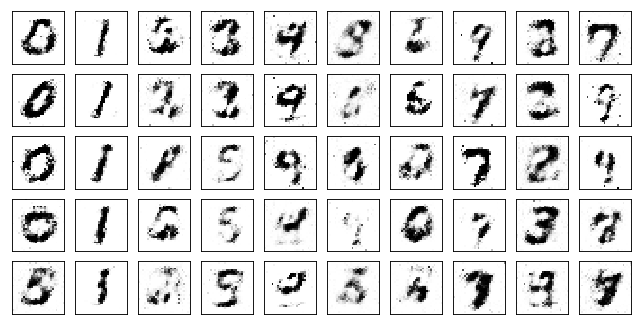

Test losses. G: 2.1431, D: 0.1774
Train Epoch: 18 [0/50000 (0%)]	Losses G: 2.2675, D: 0.3187
Train Epoch: 18 [25000/50000 (50%)]	Losses G: 2.9279, D: 0.2946
Train Epoch: 18 [50000/50000 (100%)]	Losses G: 2.6625, D: 0.2898


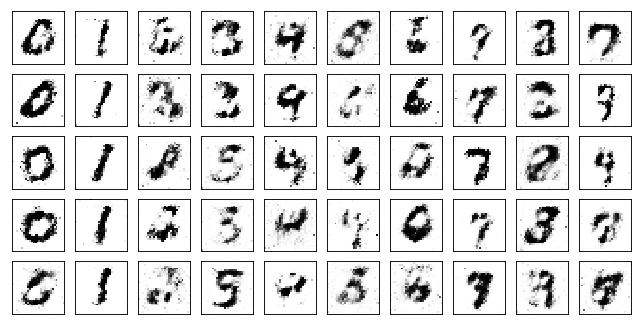

Test losses. G: 2.5080, D: 0.1756
Train Epoch: 19 [0/50000 (0%)]	Losses G: 2.5896, D: 0.2578
Train Epoch: 19 [25000/50000 (50%)]	Losses G: 3.2146, D: 0.1907
Train Epoch: 19 [50000/50000 (100%)]	Losses G: 2.3579, D: 0.2561


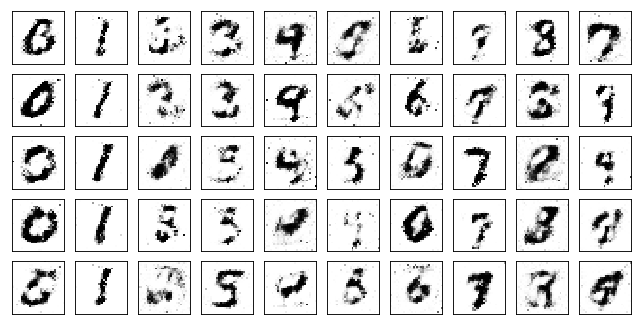

Test losses. G: 2.2211, D: 0.1785
Train Epoch: 20 [0/50000 (0%)]	Losses G: 3.1588, D: 0.2926
Train Epoch: 20 [25000/50000 (50%)]	Losses G: 2.7729, D: 0.1969
Train Epoch: 20 [50000/50000 (100%)]	Losses G: 3.2292, D: 0.2015


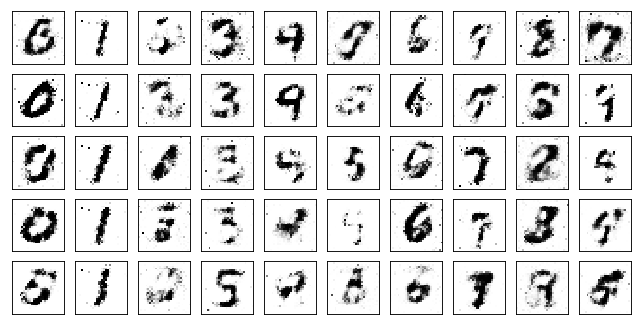

Test losses. G: 3.0244, D: 0.1274
Train Epoch: 21 [0/50000 (0%)]	Losses G: 3.1909, D: 0.2266
Train Epoch: 21 [25000/50000 (50%)]	Losses G: 3.5788, D: 0.1809
Train Epoch: 21 [50000/50000 (100%)]	Losses G: 3.1343, D: 0.1903


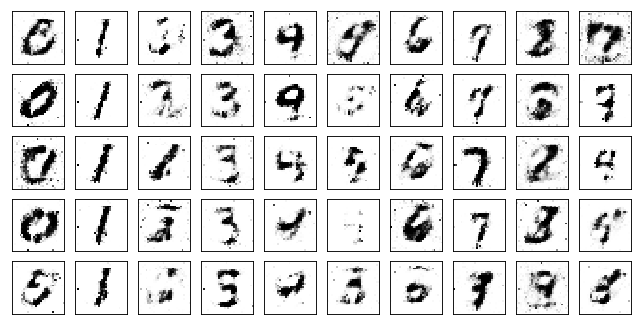

Test losses. G: 2.9495, D: 0.1470
Train Epoch: 22 [0/50000 (0%)]	Losses G: 2.9685, D: 0.2065
Train Epoch: 22 [25000/50000 (50%)]	Losses G: 3.5741, D: 0.2097
Train Epoch: 22 [50000/50000 (100%)]	Losses G: 2.9897, D: 0.2509


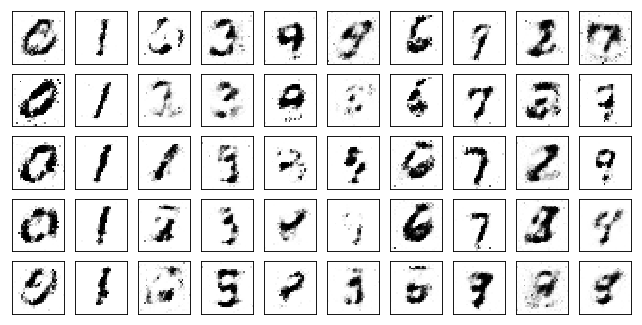

Test losses. G: 2.6186, D: 0.1763
Train Epoch: 23 [0/50000 (0%)]	Losses G: 2.9681, D: 0.2817
Train Epoch: 23 [25000/50000 (50%)]	Losses G: 2.4339, D: 0.2680
Train Epoch: 23 [50000/50000 (100%)]	Losses G: 2.3689, D: 0.2262


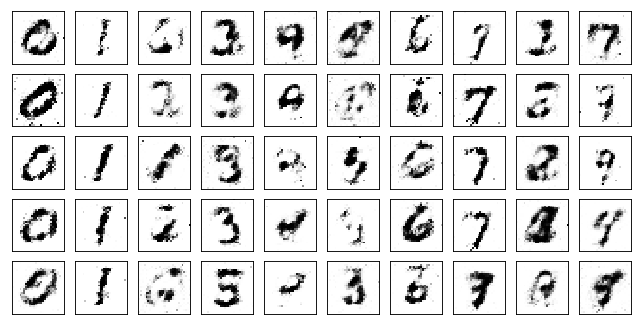

Test losses. G: 2.3641, D: 0.1516
Train Epoch: 24 [0/50000 (0%)]	Losses G: 3.0602, D: 0.2965
Train Epoch: 24 [25000/50000 (50%)]	Losses G: 3.3478, D: 0.2100
Train Epoch: 24 [50000/50000 (100%)]	Losses G: 2.3295, D: 0.2897


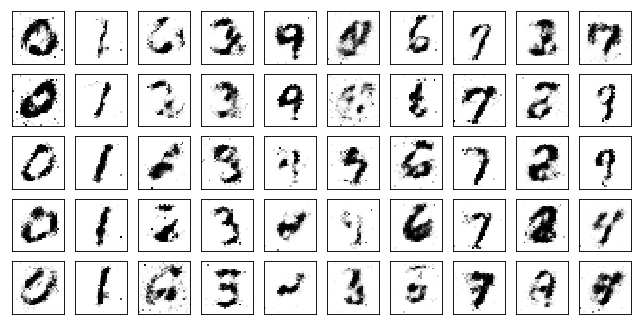

Test losses. G: 2.1288, D: 0.1649
Train Epoch: 25 [0/50000 (0%)]	Losses G: 2.9959, D: 0.2800
Train Epoch: 25 [25000/50000 (50%)]	Losses G: 2.8255, D: 0.3031
Train Epoch: 25 [50000/50000 (100%)]	Losses G: 2.9599, D: 0.2591


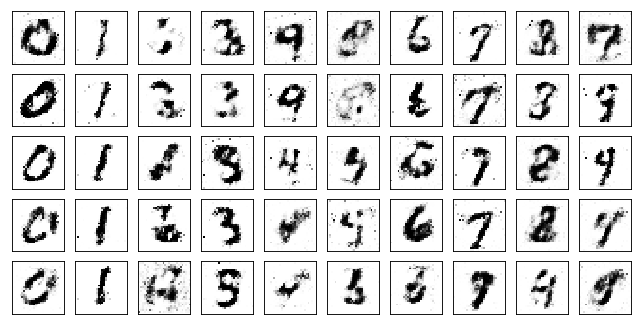

Test losses. G: 2.8812, D: 0.2055
Train Epoch: 26 [0/50000 (0%)]	Losses G: 2.8164, D: 0.2840
Train Epoch: 26 [25000/50000 (50%)]	Losses G: 2.8187, D: 0.3655
Train Epoch: 26 [50000/50000 (100%)]	Losses G: 2.9809, D: 0.3708


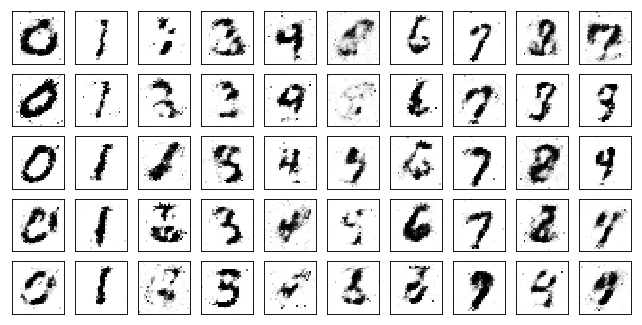

Test losses. G: 2.7221, D: 0.2607
Train Epoch: 27 [0/50000 (0%)]	Losses G: 2.4654, D: 0.3538
Train Epoch: 27 [25000/50000 (50%)]	Losses G: 2.2630, D: 0.3702
Train Epoch: 27 [50000/50000 (100%)]	Losses G: 2.3503, D: 0.2730


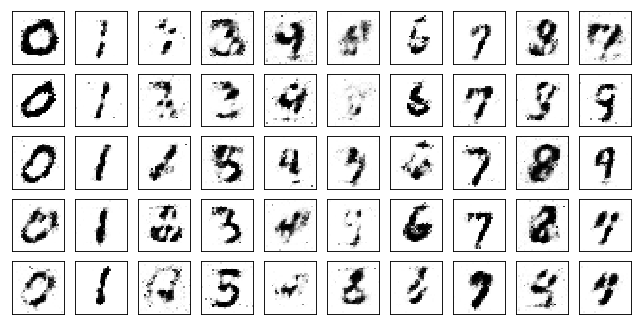

Test losses. G: 2.2600, D: 0.1811
Train Epoch: 28 [0/50000 (0%)]	Losses G: 3.0056, D: 0.2768
Train Epoch: 28 [25000/50000 (50%)]	Losses G: 2.9968, D: 0.2237
Train Epoch: 28 [50000/50000 (100%)]	Losses G: 2.4491, D: 0.2325


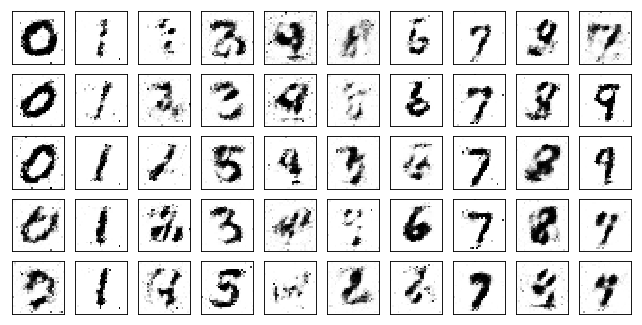

Test losses. G: 2.4800, D: 0.1559
Train Epoch: 29 [0/50000 (0%)]	Losses G: 2.8009, D: 0.2348
Train Epoch: 29 [25000/50000 (50%)]	Losses G: 2.9562, D: 0.2316
Train Epoch: 29 [50000/50000 (100%)]	Losses G: 2.1958, D: 0.2983


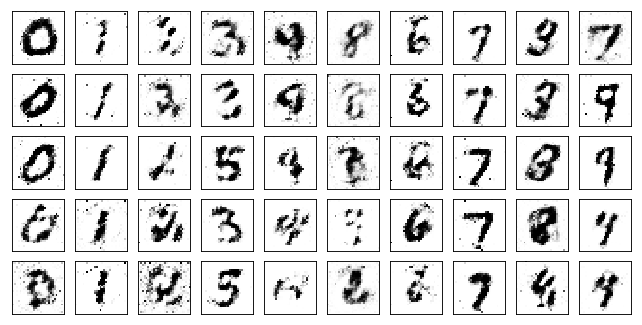

Test losses. G: 2.2198, D: 0.2067
Train Epoch: 30 [0/50000 (0%)]	Losses G: 2.3230, D: 0.2816
Train Epoch: 30 [25000/50000 (50%)]	Losses G: 2.4416, D: 0.2691
Train Epoch: 30 [50000/50000 (100%)]	Losses G: 2.7270, D: 0.2615


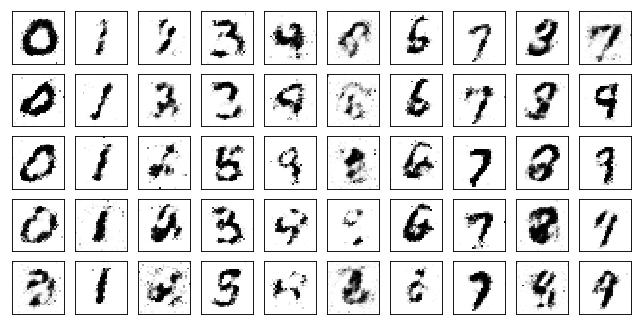

Test losses. G: 2.5850, D: 0.1450


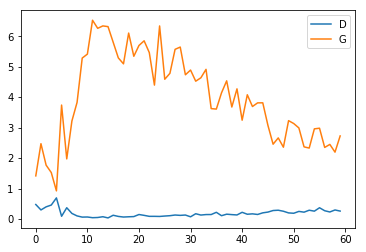

In [17]:
for epoch in range(1, 31):
    G.train()
    D.train()
    train(epoch, G, D, train_log)
    G.eval()
    D.eval()
    test(G, D, valid_loader, epoch, test_log)
plt.plot(train_log['D'], label='D')
plt.plot(train_log['G'], label='G')
plt.legend()
plt.show()

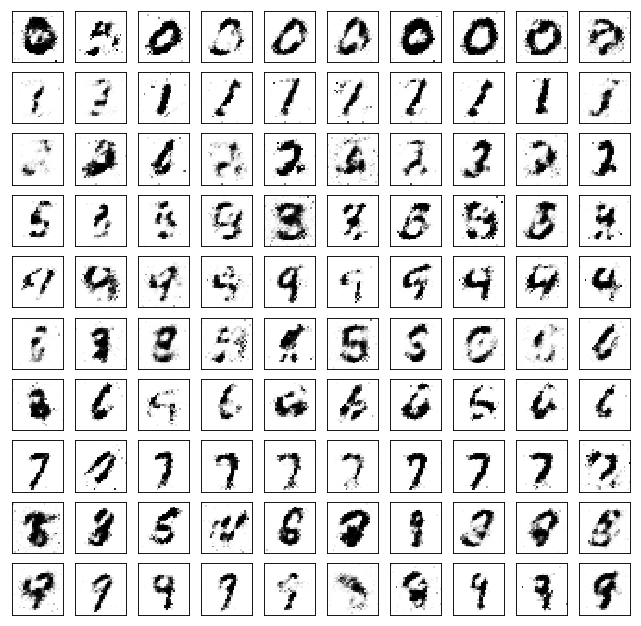

In [18]:
samples = torch.randn((100, 100))
targets = []
for i in range(10):
    targets.extend([i] * 10)
targets = F.one_hot(torch.Tensor(targets).long(), 10)

with torch.no_grad():
    data = G(samples, targets).data.numpy().reshape(-1, 1, 28, 28)
plot_mnist(data, (10, 10))

In [19]:
torch.save(G.state_dict(), 'G.model')
torch.save(D.state_dict(), 'D.model')

In [20]:
torch.save(G_optimizer.state_dict(), 'G.opt')
torch.save(D_optimizer.state_dict(), 'D.opt')